# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Introduction

Analysis of different AI techniques for short term water demand forecasting for the 

#### 1. Univariate Model

In [16]:
# imports 
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
import datetime as dt
import warnings
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt
from IPython.display import Image

%matplotlib inline

# Import necessary packages
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# custom modules
from common.utils import TimeSeriesTensor, create_evaluation_df, load_data

# imports for time series forecasting
#from sktime.forecasting.base import ForecastingHorizon
#from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
#from sktime.forecasting.naive import NaiveForecaster

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")

In [17]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowData.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)

,dma_a,dma_b,dma_c,dma_d,dma_e,dma_f,dma_g,dma_h,dma_i,dma_j
date_time,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,3.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,NaN,3.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,3.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
weather_data.head(3)

,rain_depth,air_temp,air_humid,windspeed
date_time,,,,
2021-01-01 00:00:00,0.00,7.20,79.00,9.00
2021-01-01 01:00:00,0.00,7.30,79.00,6.00
2021-01-01 02:00:00,0.00,7.60,78.00,4.00


In [6]:
# NN parameters required in data prep
T = 6
HORIZON = 1

In [29]:
# clean data

# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]

# removing large areas of missing data
inflow_data = inflow_data.dropna(axis=0, thresh=int(0.7*inflow_data.shape[1]))
weather_data = weather_data.dropna(axis=0, thresh=int(0.7*weather_data.shape[1]))

# set frequency
inflow_data = inflow_data.asfreq(pd.offsets.Hour(), method='pad')
weather_data = weather_data.asfreq(pd.offsets.Hour(), method='pad')

# fill missing using ...
inflow_data_imputed = inflow_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()
weather_data_imputed = weather_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()

temp_mode = 0 # What default value to take?No
inflow_data_imputed['dma_a'] = inflow_data_imputed['dma_a'].fillna(temp_mode)
inflow_data_imputed['dma_a'].isnull().sum()

# splitting data
pc_train = 0.6 # proportion of data for training
pc_vali = 0.3
pc_test = 0.1 # proportion of data for testing

nt_train = int(len(inflow_data_imputed)*pc_train)
nt_vali = int(len(inflow_data_imputed)*pc_vali)

# train data
data_train = {
    'd': inflow_data_imputed[:nt_train],
    'w': weather_data_imputed[(weather_data_imputed.index>=inflow_data_imputed[:nt_train].index[0]) 
    & (weather_data_imputed.index<inflow_data_imputed[nt_train:nt_train+nt_vali].index[0])],
}

# validation data
data_vali = {
    'd': inflow_data_imputed[nt_train-T:nt_train+nt_vali],
    'w': weather_data_imputed[(weather_data_imputed.index>=inflow_data_imputed[nt_train-T:nt_train+nt_vali].index[0]) 
    & (weather_data_imputed.index<inflow_data_imputed[nt_train+nt_vali:].index[0])],
}

# test data
data_test = {
    'd': inflow_data_imputed[nt_train+nt_vali-T:],
    'w': weather_data_imputed[(weather_data_imputed.index>=inflow_data_imputed[nt_train+nt_vali-T:].index[0]) 
    & (weather_data_imputed.index<=inflow_data_imputed[nt_train+nt_vali:].index[-1])],
}

print('Training data shape: ', data_train['d'].shape)
print('Test data shape: ', data_test['d'].shape)


Training data shape:  (13664, 10)
Test data shape:  (690, 10)


In [32]:
data_train['d'].to_csv('../data/inflow_data_imputed.csv')
data_train['w'].to_csv('../data/weather_data_imputed.csv')

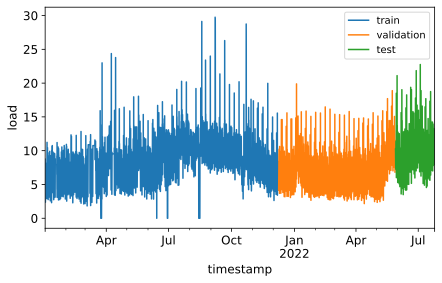

In [6]:
# plot data

data_train['d'][['dma_a']].rename(columns={'dma_a':'train'}) \
    .join(data_vali['d'][['dma_a']] \
.rename(columns={'dma_a':'validation'}), how='outer') \
    .join(data_test['d'][['dma_a']]
.rename(columns={'dma_a':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(7, 4), fontsize=12)

plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [7]:
# prepare train dataset
# Step 1: get the train data from the correct data range
train = data_train['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'})
vali = data_vali['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'})
test = data_test['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'}) 
    
# Step 2: scale data to be in range (0, 1). 
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
vali['load'] = scaler.fit_transform(vali)
test['load'] = scaler.fit_transform(test)
 
# Step 3: shift the dataframe to create the input samples
train_shifted = train.copy()
vali_shifted = vali.copy()
test_shifted = test.copy()

train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
vali_shifted['y_t+1'] = vali_shifted['load'].shift(-1, freq='H')
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')

for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')
    vali_shifted[str(T-t)] = vali_shifted['load'].shift(T-t, freq='H')
    test_shifted[str(T-t)] = test_shifted['load'].shift(T-t, freq='H')

y_col = 'y_t+1'
X_cols = ['load_t-5',
             'load_t-4',
             'load_t-3',
             'load_t-2',
             'load_t-1',
             'load_t']

train_shifted.columns = ['load_original']+[y_col]+X_cols
vali_shifted.columns = ['load_original']+[y_col]+X_cols
test_shifted.columns = ['load_original']+[y_col]+X_cols
    
# Step 4: discard missing values
train_shifted = train_shifted.dropna(how='any')
vali_shifted = vali_shifted.dropna(how='any')
test_shifted = test_shifted.dropna(how='any')


In [8]:
# Step 5: transform this pandas dataframe into a numpy array
y_train = train_shifted[y_col].values
y_vali = vali_shifted[y_col].values
y_test = test_shifted[y_col].values

X_train = train_shifted[X_cols].values
X_vali = vali_shifted[X_cols].values
X_test = test_shifted[X_cols].values

X_train = X_train.reshape(X_train.shape[0], T, 1)
X_vali = X_vali.reshape(X_vali.shape[0], T, 1)
X_test = X_test.reshape(X_test.shape[0], T, 1)


In [9]:
# add model definition variables
LATENT_DIM = 5 
BATCH_SIZE = 24
EPOCHS = 10

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

model.compile(optimizer='RMSprop', loss='mse')
model.summary()

GRU_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5)                 │        120 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
# fitting model
model_history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_vali, y_vali),
                    callbacks=[GRU_earlystop],
                    verbose=1)


Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0032 - val_loss: 0.0083
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0082
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0084
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0082
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0081
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0082
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0081
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 - val_loss: 0.0081
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0082
Epoch 10/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0081


In [11]:
# evaluate model fit
ts_predictions = model.predict(X_test)
ts_predictions
ev_ts_data = pd.DataFrame(ts_predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
ev_ts_data['timestamp'] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars='timestamp', value_name='prediction', var_name='h')
ev_ts_data['actual'] = np.transpose(y_test).ravel()
ev_ts_data[['prediction', 'actual']] = scaler.inverse_transform(ev_ts_data[['prediction', 'actual']])
ev_ts_data.head(10)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,timestamp,h,prediction,actual
0,2022-05-29 00:00:00,t+1,8.53,7.70
1,2022-05-29 01:00:00,t+1,7.92,8.15
2,2022-05-29 02:00:00,t+1,8.23,8.06
3,2022-05-29 03:00:00,t+1,8.19,7.26
4,2022-05-29 04:00:00,t+1,7.55,7.44
5,2022-05-29 05:00:00,t+1,7.63,8.38
6,2022-05-29 06:00:00,t+1,8.40,9.38
7,2022-05-29 07:00:00,t+1,9.27,9.97
8,2022-05-29 08:00:00,t+1,9.82,10.96
9,2022-05-29 09:00:00,t+1,10.64,11.36


In [12]:
# means abs err of model predictions
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()
 
mape(ev_ts_data['prediction'], ev_ts_data['actual'])


0.12939705441434093

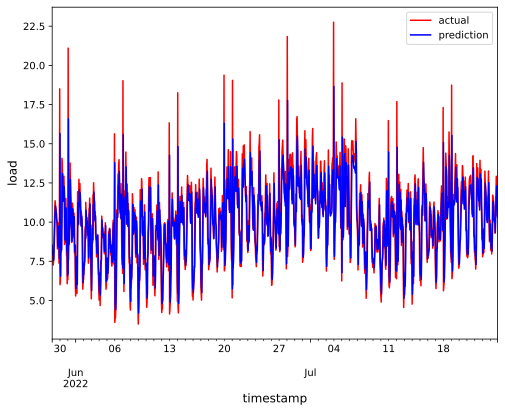

In [13]:
# plot predicted vs actual
ev_ts_data.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(8, 6))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


#### 2. Multivariate Model

In [14]:
T = 6
HORIZON = 1

In [63]:
# prepare train dataset with weather
# Step 1: get the train data from the correct data range
var = 'air_humid'

train = data_train['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'})
train['temp'] = data_train['w'].copy()[var]
vali = data_vali['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'})
vali['temp'] = data_vali['w'].copy()[var]
test = data_test['d'].copy()[['dma_a']].rename(columns={'dma_a':'load'}) 
test['temp'] = data_test['w'].copy()[var]

# include prior T-1 timesteps to validation set
back_ts_data = vali.index[0] - dt.timedelta(hours=T-1)
vali = vali.copy()[(vali.index>=back_ts_data)][['load', 'temp']]

# Step 2: scale data to be in range (0, 1). 
y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()

train[['load', 'temp']] = X_scaler.fit_transform(train)
vali[['load', 'temp']] = X_scaler.transform(vali)

# Prep data with TimeSeriesTensor class
tensor = {'X':(range(-T+1, 1), ['load', 'temp'])}
ts_train_inp = TimeSeriesTensor(dataset=train,
                            target='load',
                            H=HORIZON,
                            tensor_structure=tensor,
                            freq='H',
                            drop_incomplete=True)

valid_inputs = TimeSeriesTensor(vali, "load", HORIZON, tensor)


In [64]:
# Define parameters
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50
 
#Define model
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

model.compile(optimizer='RMSprop', loss='mse')
 
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 5)                 │        135 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_6 (Dense)                 │ (None, 1)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Run model
GRU_earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

model_history = model.fit(ts_train_inp['X'],
                    ts_train_inp['target'],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(valid_inputs['X'], valid_inputs['target']),
                    callbacks=[GRU_earlystop],
                    verbose=1)


Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0242 - val_loss: 0.0032
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - loss: 0.0030 - val_loss: 0.0031
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0028 - val_loss: 0.0030
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0028 - val_loss: 0.0036
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0028 - val_loss: 0.0031
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.0031 - val_loss: 0.0030


In [66]:
# Evaluate model fit
back_ts_data = test.index[0] - dt.timedelta(hours=T-1)
test = test.copy()[(test.index>=back_ts_data)][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor)
 
ts_predictions = model.predict(test_inputs['X'])
 
ev_ts_data = create_evaluation_df(ts_predictions, test_inputs, HORIZON, y_scaler)
ev_ts_data.head()


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,timestamp,h,prediction,actual
0,2022-05-29 00:00:00,t+1,8.53,7.70
1,2022-05-29 01:00:00,t+1,7.98,8.15
2,2022-05-29 02:00:00,t+1,8.11,8.06
3,2022-05-29 03:00:00,t+1,8.07,7.26
4,2022-05-29 04:00:00,t+1,7.62,7.44


In [67]:
# Evaluate model fit
mape(ev_ts_data['prediction'], ev_ts_data['actual'])

0.13468684708974693

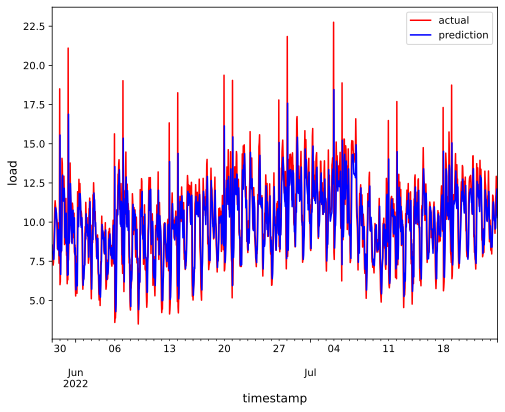

In [68]:
# plot predicted vs actual
ev_ts_data.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(8, 6))
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()
